In [46]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import seaborn as sns

from scipy.stats import zscore, pearsonr
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from tqdm import tqdm

In [2]:
dat = pd.read_pickle('../datasets/NNN/unit_data_full.pkl')

In [3]:
# =========================
# CONFIG
# =========================
ONSET_MS = 0          # stimulus onset (ms)
WINDOW_MS = 350        # analyze 0-300 ms post onset
BIN_MS = 1             # temporal bin size (ms). If not 1, change indices below
K_RANGE = range(2, 11) # candidates for number of clusters
RANDOM_STATE = 0
N_INIT = "auto"        # or an int (e.g., 20) if on older sklearn
MAX_IMAGES_FOR_RSA = None   # to keep RSA runtime reasonable. None for all images
RSA_METRIC = "correlation"       # correlation type when comparing RDM vectors
SAVE_PREFIX = "clustering_out"

In [49]:
fig, ax = plt.subplots(figsize=(6,4))

# (optional) fix y-lims to avoid flicker
# ylo, yhi = -0.5, 2.0

for i in tqdm(np.random.choice(range(len(dat)), size=50)):
    row = dat.iloc[i]
    A = np.asarray(row["img_psth"])
    avg1 = A.mean(axis=1)
    avg2 = np.asarray(row["avg_psth"])

    ax.cla()
    sns.lineplot(x=np.arange(len(avg1)), y=avg1, ax=ax, label="mean over images")
    sns.lineplot(x=np.arange(len(avg2)), y=avg2, ax=ax, label="avg_psth")
    ax.set_title(f"Unit {i}")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("FR (a.u.)")
    ax.legend()
    # ax.set_ylim(ylo, yhi)

    display(fig)               # draw current frame
    time.sleep(0.4)            # hold on screen
    clear_output(wait=True)    # erase before next frame

plt.close(fig)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.19it/s]


In [4]:
def get_unit_timecourse(row, start=None, end=None):
    """
    Return the unit's avg PSTH within the analysis window.
    If avg_psth is missing, derive it by averaging img_psth across images.
    Ensures shape (T,) where T=end-start.
    """
    avg = row['avg_psth']
    if avg is None or (isinstance(avg, float) and np.isnan(avg)):
        A = np.asarray(row['img_psth'])  # (time, images)
        if A.ndim != 2:
            raise ValueError("img_psth must be 2D (time x images)")
        avg = A.mean(axis=1)
    avg = np.asarray(avg)
    if avg.ndim != 1:
        raise ValueError("avg_psth must be 1D (time,)")
    # take all values if start/end is not specified
    if start is None:
        start = 0
        end = len(avg)
    if len(avg) < end:
        raise ValueError(f"avg_psth length {len(avg)} < required end index {end}")
    return avg[start:end]  # (T,)

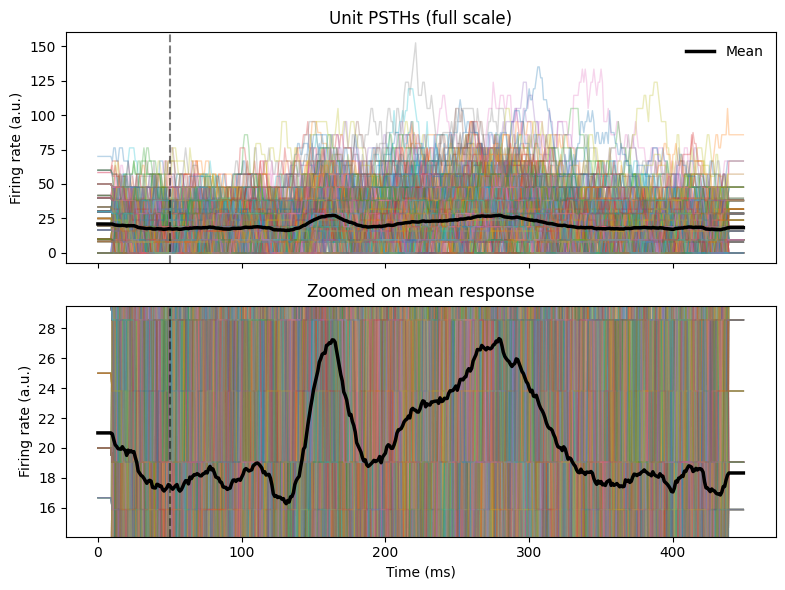

In [5]:
unit_idx = 500           # <-- pick your unit
N_SHOW = 500            # image psth's to show

A = np.asarray(dat.iloc[unit_idx]["img_psth"])  # shape: (time, images)
T, I = A.shape
time_axis = np.arange(T) * BIN_MS

# pick some random images (or your own indices)
rng = np.random.default_rng(0)
img_ids = np.sort(rng.choice(I, size=N_SHOW, replace=False))

fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# ---------- Full view ----------
ax = axes[0]
for img in img_ids:
    sns.lineplot(x=time_axis, y=A[:, img], alpha=0.3, lw=1.0, ax=ax)
ax.plot(time_axis, A[:, img_ids].mean(axis=1), color='k', lw=2.5, label='Mean')
ax.axvline(50, ls="--", color="k", alpha=0.5)
ax.set_title("Unit PSTHs (full scale)")
ax.set_ylabel("Firing rate (a.u.)")
ax.legend(frameon=False)

# ---------- Zoomed view ----------
ax = axes[1]
for img in img_ids:
    sns.lineplot(x=time_axis, y=A[:, img], alpha=0.2, lw=1.0, ax=ax)
mean_trace = A[:, img_ids].mean(axis=1)
ax.plot(time_axis, mean_trace, color='k', lw=2.5)
ax.axvline(50, ls="--", color="k", alpha=0.5)
ax.set_title("Zoomed on mean response")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Firing rate (a.u.)")

# Zoom in on the y-axis around the mean trace
margin = 0.2 * (mean_trace.max() - mean_trace.min())
ax.set_ylim(mean_trace.min() - margin, mean_trace.max() + margin)

plt.tight_layout()
plt.show()

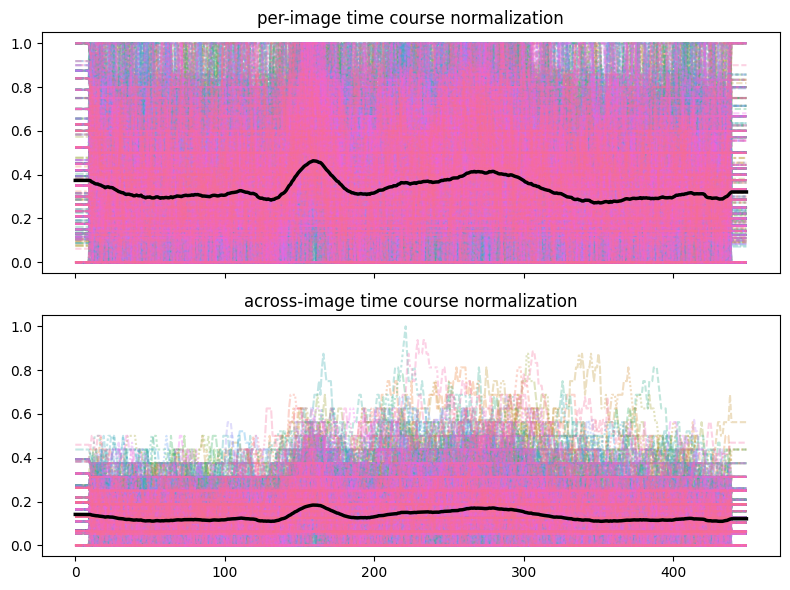

In [6]:
A = np.asarray(dat.iloc[unit_idx]["img_psth"])  # (time, images)

fig,axes = plt.subplots(2,1, figsize=(8,6), sharex=True)

ax = axes[0]
# normalize per image (shape-only)
A_norm_time = A / (A.max(axis=0, keepdims=True) + 1e-9)
sns.lineplot(A_norm_time, alpha=0.3, ax=ax)
mean_trace = A_norm_time.mean(axis=1)
ax.plot(np.arange(len(A)), mean_trace, color='k', lw=2.5)
ax.set_title('per-image time course normalization')
ax.legend().remove()

ax = axes[1]
# normalize per unit (all images)
A_norm_unit = A / (A.max() + 1e-9)
sns.lineplot(A_norm_unit, alpha=0.3, ax=ax)
mean_trace = A_norm_unit.mean(axis=1)
ax.plot(np.arange(len(A)), mean_trace, color='k', lw=2.5)
ax.set_title('across-image time course normalization')
ax.legend().remove()

plt.tight_layout()
plt.show()

In [5]:
# start and end times calculated from CONFIG
start = int(ONSET_MS / BIN_MS)
end   = start + int(WINDOW_MS / BIN_MS)

timecourses = []
valid_idx = []  # track which rows succeed
for i, row in dat.iterrows():
    try:
        tc = get_unit_timecourse(row, start, end)
        timecourses.append(tc)
        valid_idx.append(i)
    except Exception as e:
        # skip units that don't have valid PSTH
        print(f"Skipping unit {i}: {e}")
        pass
    
X = np.vstack(timecourses)  # (n_valid_units, T)

# Z-score each unit across time (mean=0, std=1)
X = zscore(X, axis=1)
# Replace any NaNs from zero-variance rows with zeros
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

In [6]:
# =========================
# INERTIA/SILHOUETTE: choose K
# =========================
sil_scores = []
labels_by_k = {}
inertias = {}
for k in tqdm(K_RANGE):
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=N_INIT)
    lab = km.fit_predict(X)
    # inertia to measure fit of k clusters
    km.fit(X)
    inertias[k] = km.inertia_
    labels_by_k[k] = lab
    # alternatively, use silhouette
    # requires >1 cluster and less than n_samples
    sil = silhouette_score(X, lab)
    sil_scores.append((k, sil))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:02<00:00,  6.98s/it]


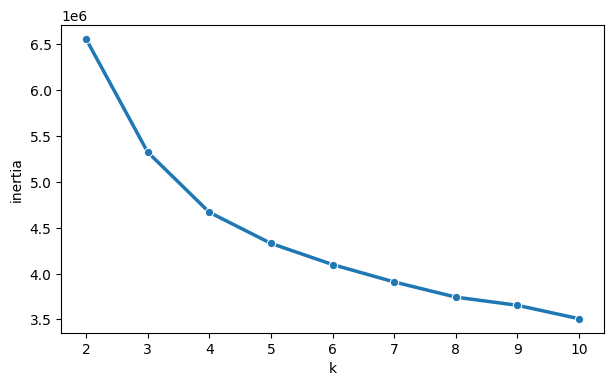

Silhouette scores:
  k=2: silhouette=0.2267
  k=3: silhouette=0.2359
  k=4: silhouette=0.2052
  k=5: silhouette=0.1706
  k=6: silhouette=0.1615
  k=7: silhouette=0.1534
  k=8: silhouette=0.1547
  k=9: silhouette=0.1587
  k=10: silhouette=0.1576
=> Selected k=3 (silhouette=0.2359)


In [7]:
# by INERTIA
df = pd.DataFrame({
    "k": list(inertias.keys()),
    "inertia": list(inertias.values())
})

# seaborn lineplot
plt.figure(figsize=(7, 4))
sns.lineplot(data=df, x="k", y="inertia", marker="o", linewidth=2.5)
plt.show()

# by SILHOUETTE score
# Pick best K
best_k, best_sil = max(sil_scores, key=lambda t: t[1])
labels = labels_by_k[best_k]

print("Silhouette scores:")
for k, s in sil_scores:
    print(f"  k={k}: silhouette={s:.4f}")
print(f"=> Selected k={best_k} (silhouette={best_sil:.4f})")

# Attach labels back to the original `dat`
dat['cluster'] = np.nan
dat.loc[valid_idx, 'cluster'] = labels

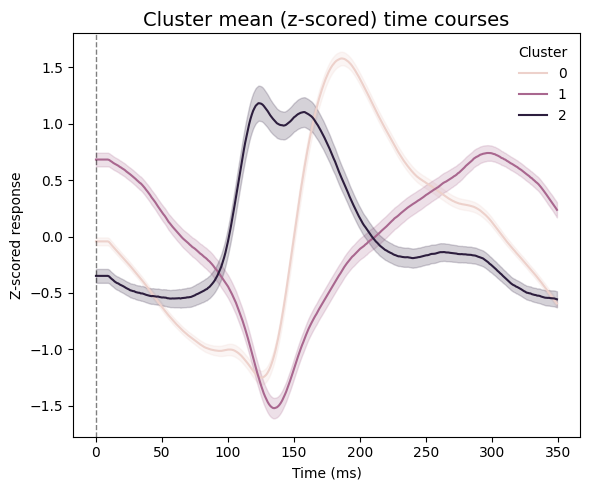

In [8]:
# =========================
# PLOTS: cluster mean time courses
# =========================
T = X.shape[1]
time_axis = np.arange(start, end)  # time in ms

df_plot = pd.DataFrame({
    "time": np.tile(time_axis, X.shape[0]),
    "response": X.flatten(),
    "cluster": np.repeat(labels, T)
})

# --- Seaborn plot ---
plt.figure(figsize=(6, 5))
sns.lineplot(
    data=df_plot,
    x="time",
    y="response",
    hue="cluster",
    errorbar=("se", 10), # for viz
)

# onset line
plt.axvline(ONSET_MS, ls="--", lw=1, color="k", alpha=0.5)

plt.title("Cluster mean (z-scored) time courses", fontsize=14)
plt.xlabel("Time (ms)")
plt.ylabel("Z-scored response")
plt.legend(title="Cluster", frameon=False)
plt.tight_layout()
plt.show()

In [67]:
# ---------- A) SUB-CLUSTER UNITS BY PSTH (within a cluster_id) ----------
def subcluster_units_by_psth(
    dat, cluster_id, onset_ms=50, window_ms=300, bin_ms=1,
    k_range=range(2, 9), random_state=0, label_col_prefix="unit_subcluster"
):
    sub = dat[dat["cluster"] == cluster_id].copy()
    if sub.empty:
        raise ValueError(f"No units for cluster_id={cluster_id}")

    start = onset_ms // bin_ms
    end   = start + (window_ms // bin_ms)

    rows, idx_keep = [], []
    for i, r in sub.iterrows():
        # prefer avg_psth; fallback to mean over images of img_psth
        avg = r.get("avg_psth", None)
        if avg is None or (isinstance(avg, float) and np.isnan(avg)):
            A = np.asarray(r["img_psth"])  # (time, images)
            if A.ndim != 2 or A.shape[0] < end: 
                continue
            avg = A.mean(axis=1)
        avg = np.asarray(avg)
        if avg.ndim != 1 or avg.shape[0] < end:
            continue
        rows.append(avg[start:end])
        idx_keep.append(i)

    X = np.vstack(rows)                          # (n_units_in_cluster, T)
    X = zscore(X, axis=1)
    X = np.nan_to_num(X, 0.0)

    # choose k via silhouette
    best_k, best_score = max(
        ((k, silhouette_score(X, KMeans(k, n_init="auto", random_state=random_state).fit_predict(X)))
         for k in k_range),
        key=lambda t: t[1]
    )

    km = KMeans(best_k, n_init="auto", random_state=random_state)
    unit_labels = km.fit_predict(X)

    # plot mean ± 95% CI per subcluster
    T = X.shape[1]
    time_axis = np.arange(start, end)
    df_plot = pd.DataFrame({
        "time": np.tile(time_axis, X.shape[0]),
        "resp": X.ravel(),
        "subcluster": np.repeat(unit_labels, T)
    })
    plt.figure(figsize=(7,5))
    sns.lineplot(data=df_plot, x="time", y="resp", hue="subcluster",
                 errorbar=("ci", 95), lw=2)
    plt.axvline(onset_ms, ls="--", color="k", alpha=0.5)
    plt.title(f"Cluster {cluster_id}: unit subclusters by PSTH (k={best_k})")
    plt.xlabel("Time (ms)"); plt.ylabel("Z-scored response")
    plt.tight_layout(); plt.show()

    return unit_labels, best_k


# ---------- B) CLUSTER TIME POINTS BY REPRESENTATIONAL GEOMETRY ----------
def cluster_timepoints_by_representation(
    dat, cluster_id, onset_ms=0, window_ms=450, bin_ms=1,
    max_images=None, k_range=range(2, 9), random_state=0):
    sub = dat[dat["cluster"] == cluster_id]
    if sub.empty:
        raise ValueError(f"No units for cluster_id={cluster_id}")

    # stack img_psth -> (U, T_full, I)
    arrays = [np.asarray(x) for x in sub["img_psth"]]
    shapes = {a.shape for a in arrays}
    if len(shapes) != 1:
        raise ValueError(f"Inconsistent img_psth shapes: {shapes}")
    X = np.stack(arrays, axis=0)
    U, T_full, I = X.shape

    start = onset_ms // bin_ms
    end   = start + (window_ms // bin_ms)

    # subsample images for speed if needed
    if max_images is not None and I > max_images:
        rng = np.random.default_rng(random_state)
        img_sel = np.sort(rng.choice(I, size=max_images, replace=False))
    else:
        img_sel = np.arange(I)

    X = X[:, start:end, :][:, :, img_sel]   # (U, T, I_sel)
    U, T, I = X.shape

    # z-score across units at each (t, i)
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True) + 1e-8
    Zu = (X - mu) / sd                      # (U, T, I)
    
    return Zu

#     # per-time image×image RDM vectors (correlation distance)
#     RDM_vecs = []
#     for t in range(T):
#         V = Zu[:, t, :].T                   # (I, U): images as observations, units as features
#         rdm_vec = pdist(V, metric="correlation")  # 1 - Pearson r
#         RDM_vecs.append(rdm_vec)
#     RDM_vecs = np.vstack(RDM_vecs)          # (T, P) [P = units * units-1 / 2]

#     # normalize rows; cluster time points
#     Xtime = (RDM_vecs - RDM_vecs.mean(axis=1, keepdims=True)) / (RDM_vecs.std(axis=1, keepdims=True) + 1e-9)

#     best_k, best_score = max(
#         ((k, silhouette_score(Xtime, KMeans(k, n_init="auto", random_state=random_state).fit_predict(Xtime)))
#          for k in k_range),
#         key=lambda t: t[1]
#     )

#     km = KMeans(best_k, n_init="auto", random_state=random_state)
#     time_labels = km.fit_predict(Xtime)

#     # simple strip view of time labels
#     plt.figure(figsize=(9,1.6))
#     sns.heatmap(time_labels[np.newaxis, :], cmap="tab10", cbar=False)
#     plt.title(f"Cluster {cluster_id}: time clusters (k={best_k})")
#     plt.xlabel("Time (ms)"); plt.yticks([])
#     plt.tight_layout(); plt.show()

#     rsa = None
#     if return_rsa:
#         # make time×time RSA for a sorted-block view
#         X0 = Xtime - Xtime.mean(axis=1, keepdims=True)
#         X0 /= (np.linalg.norm(X0, axis=1, keepdims=True) + 1e-12)
#         rsa = X0 @ X0.T                       # (T, T)

#         order = np.argsort(time_labels)
#         rsa_sorted = rsa[order][:, order]
#         plt.figure(figsize=(6,5))
#         sns.heatmap(rsa_sorted, vmin=0, vmax=1, cmap="Spectral_r")
#         plt.title(f"Time×Time RSA (Cluster {cluster_id}, reordered by time clusters)")
#         plt.tight_layout(); plt.show()

#     return time_labels, best_k, RDM_vecs, rsa

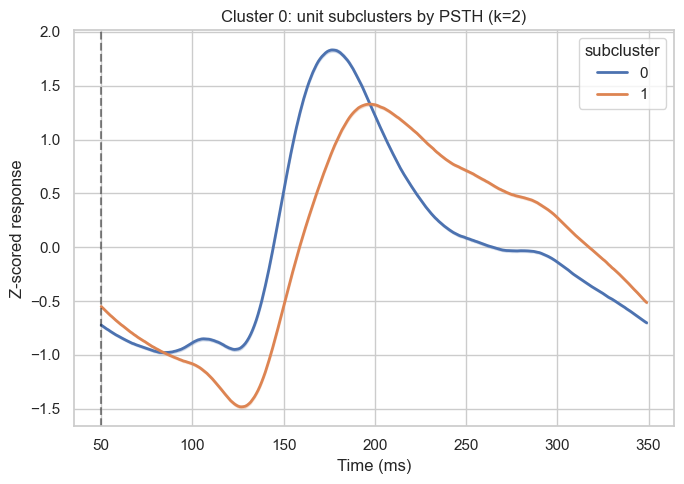

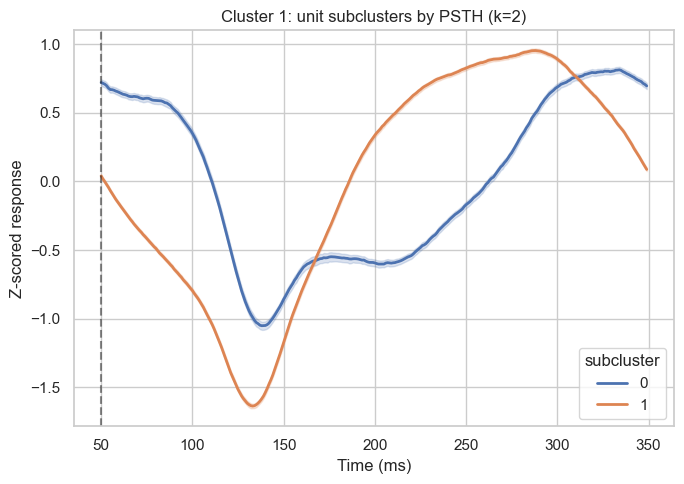

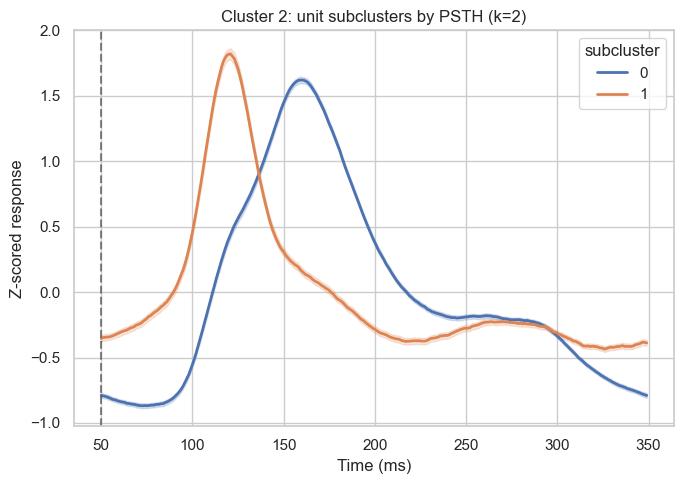

In [56]:
for cluster_id in range(3):
    # A) sub-cluster units by PSTH
    unit_labels, best_k_units = subcluster_units_by_psth(dat, cluster_id)

In [68]:
# B) cluster time points by representational geometry
Zu = cluster_timepoints_by_representation(dat, cluster_id)
Zu.shape

(7383, 300, 1072)

In [9]:
# =========================
# RSA per cluster (time × time similarity)
# =========================
# For RSA, we use img_psth (time x images) for units in each cluster.
# At each time bin within the window, build population-by-image matrix for that cluster:
#   M_t = (n_units_in_cluster x n_images_sub)
# Compute image×image correlation matrix at that time => similarity
# Convert to RDM vector = 1 - corr (upper triangle).
# Compare RDM vectors across all time pairs via correlation => time×time RSA.

def rdm_vector_from_matrix(M, metric='correlation'):
    """
    Args:
        M: (ndarray)
        metric: (str)
    Given a matrix M with shape (n_units, n_images), compute the image×image
    RDM and return the vectorized upper triangle (excluding diagonal).
    """
    M = np.asarray(M, dtype=float)
    # center columns (images) across units, matching the corrcoef approach
    M -= M.mean(axis=0, keepdims=True)
    M = np.nan_to_num(M, nan=0.0, posinf=0.0, neginf=0.0)
    # pdist expects observations in rows, so pass images as rows -> M.T
    rdm_vec = pdist(M.T, metric=metric)  # already 1 - corr
    return rdm_vec

def rsa_time_by_time_for_cluster(cluster_id, metric='correlation', vectorized=True):
    idx_units = np.where(dat.loc[valid_idx, 'cluster'].values == cluster_id)[0]

    # Select only the rows you want, based on cluster id
    subset = dat.iloc[idx_units]["img_psth"]

    # Convert to list of arrays
    arrays = [np.asarray(x) for x in subset]
    # shape: (units, time_points, images)
    img_psth_array = np.stack(arrays, axis=0)
    Z = img_psth_array[:, start:end, :]
    U, T, I = Z.shape

    # 1) z-score across units for each (t, i)
    mu = Z.mean(axis=0, keepdims=True)                  # (1, T, I)
    sd = Z.std(axis=0, keepdims=True) + 1e-8           # (1, T, I)
    Zu = (Z - mu) / sd                                  # (U, T, I)

    # 2) per-time image×image correlation matrices (population-based)
    #    For each t: C_t = (Zu_t^T @ Zu_t) / (U-1)


    vectorized = True
    if vectorized:
        C_time = np.einsum('uti,utj->tij', Zu, Zu) / (U - 1)   # (T, I, I)
        # C_time = np.clip(C_time, -1.0, 1.0)
    else:
        C_time = Zu.map(lambda A: pdist(np.asarray(A).T, metric=metric))
        
    RDM_time = 1.0 - C_time                                # (T, I, I)
    # 3) vectorize upper triangles to get one RDM vector per time
    iu = np.triu_indices(I, k=1)
    RDM_vecs = RDM_time[:, iu[0], iu[1]]                   # (T, P), P = I*(I-1)/2

    X = RDM_vecs - RDM_vecs.mean(axis=1, keepdims=True)     # demean per time
    den = np.linalg.norm(X, axis=1, keepdims=True) + 1e-12
    Xn = X / den
    rsa = Xn @ Xn.T   
    
    return rsa

In [14]:
cluster_id = 0

idx_units = np.where(dat.loc[valid_idx, 'cluster'].values == cluster_id)[0]
if len(idx_units) < 2:
    print(f"[RSA] Cluster {cluster_id}: not enough units ({len(idx_units)})")

# Stack img_psth for units in this cluster
# We may subsample images for speed/memory
# First, figure out number of images from the first unit
sample_unit = dat.iloc[valid_idx[idx_units[0]]]['img_psth']
A0 = np.asarray(sample_unit)
if A0.ndim != 2:
    raise ValueError("img_psth must be 2D (time x images)")
n_time, n_images = A0.shape
print(A0.shape)

# Subsample images if needed
if MAX_IMAGES_FOR_RSA is not None and n_images > MAX_IMAGES_FOR_RSA:
    rng = np.random.default_rng(RANDOM_STATE)
    img_sel = np.sort(rng.choice(n_images, size=MAX_IMAGES_FOR_RSA, replace=False))
else:
    img_sel = np.arange(n_images)
print(img_sel.shape)

# # Prepare an array: for each time t in [start:end), we will build an RDM vector
# rdm_vecs = []
# for t in tqdm(range(50, 55)):
#     # Build matrix (units x images_sel) at this time
#     rows = []
#     for u_rel in idx_units:
#         unit_idx = valid_idx[u_rel]
#         A = np.asarray(dat.iloc[unit_idx]['img_psth'])  # (time, images)
#         rows.append(A[t, img_sel])
#     M = np.vstack(rows)  # (n_units_in_cluster, n_images_sub)
#     # Normalize across units for stability (optional)
#     # M = zscore(M, axis=0)  # z-score per image across units
#     M = np.nan_to_num(M, nan=0.0, posinf=0.0, neginf=0.0)
    
#     # upper triangular of image x image RDMS
#     triu = rdm_vector_from_matrix(M)
#     rdm_vecs.append(triu)

# rdm_vecs = np.vstack(rdm_vecs)  # (T, n_pairs)
# print(rdm_vecs.shape)
# # time x time similarity by correlating RDM vectors across time
# Tloc = rdm_vecs.shape[0]
# rsa_mat = np.empty((Tloc, Tloc), dtype=float)

(450, 1072)
(1072,)


In [31]:
# how the paper does it??
cluster_id = 2

idx_units = np.where(dat.loc[valid_idx, 'cluster'].values == cluster_id)[0]

# Select only the rows you want, based on cluster id
subset = dat.iloc[idx_units]["img_psth"]

# Convert to list of arrays
arrays = [np.asarray(x) for x in subset]
# shape: (units, time_points, images)
img_psth_array = np.stack(arrays, axis=0)
Z = img_psth_array[:, start:end, :]
U, T, I = Z.shape

# 1) z-score across units for each (t, i)
mu = Z.mean(axis=0, keepdims=True)                  # (1, T, I)
sd = Z.std(axis=0, keepdims=True) + 1e-8           # (1, T, I)
Zu = (Z - mu) / sd                                  # (U, T, I)

# 2) per-time image×image correlation matrices (population-based)
#    For each t: C_t = (Zu_t^T @ Zu_t) / (U-1)


vectorized = True
if vectorized:
    C_time = np.einsum('uti,utj->tij', Zu, Zu) / (U - 1)   # (T, I, I)
    # C_time = np.clip(C_time, -1.0, 1.0)
else:
    for unit in Z:
        print(unit.shape)
        break

print(f'this shape should be time x img x img', C_time.shape)
# # average across images to get each unit's average psth
# avg_psth = np.mean(img_psth_array, axis=2)
# # normalize each timecourse
# avg_psth_norm = zscore(avg_psth, axis=1)
# # subset to specific time range
# avg_psth_norm = avg_psth_norm[:, :350]

# # rdm
# metric = 'correlation'
# rdm_vec = pdist(avg_psth_norm.T, metric=metric)
# rdm = squareform(rdm_vec)
# sns.heatmap(rdm)
# plt.title(f'Cluster {cluster_id}')

this shape should be time x img x img (350, 1072, 1072)


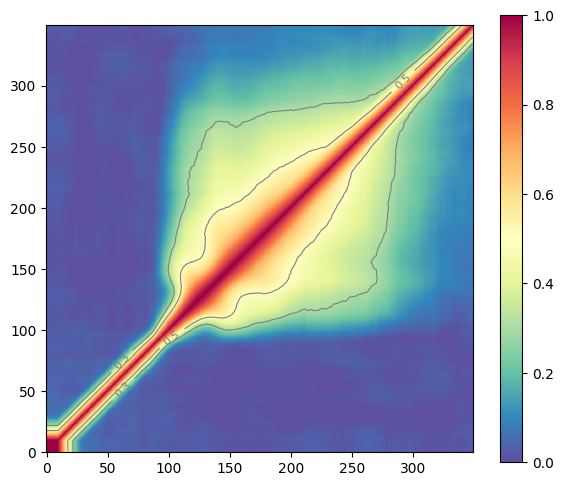

In [45]:
RDM_time = 1.0 - C_time                                # (T, I, I)

# 3) vectorize upper triangles to get one RDM vector per time
iu = np.triu_indices(I, k=1)
RDM_vecs = RDM_time[:, iu[0], iu[1]]                   # (T, P), P = I*(I-1)/2

X = RDM_vecs - RDM_vecs.mean(axis=1, keepdims=True)     # demean per time
den = np.linalg.norm(X, axis=1, keepdims=True) + 1e-12
Xn = X / den
rsa = Xn @ Xn.T   

plt.figure(figsize=(6,5))
ax = plt.imshow(rsa, vmin=0, vmax=1, origin='lower', cmap="Spectral_r")
plt.colorbar()

levels = [0.3, 0.5]
Xgrid = np.linspace(0, T-1, T)
Ygrid = np.linspace(0, T-1, T)
CS = plt.contour(Xgrid, Ygrid, rsa, levels=levels, colors='gray', linewidths=0.8)
plt.clabel(CS, fmt="%.1f", colors='gray', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
'''
10:35 --> in the middle of this
Z should be a unit-normalized psth array with size (unit, timepoint, img)
i want to create img x img RDMs, separately for each unit
this is supposed to be a vectorized version, but it takes forever

ultimately, i need to do pairwise comparisons of the RDM vector for each pair of timepoints

so t1, t2 --> corr(rdv_t1, rdv_t2)
rdv_t1 --> image x image RDM, from unit x image matrix?
yeah i think this ^^
'''
vectorized = False
unit_max = subset.max(axis=(1, 2), keepdims=True)
Z = subset / (unit_max + 1e-9)

if vectorized:
    C = np.einsum('uti,utj->uij', Z, Z) / (T - 1) 
    C.shape
else:
    for unit in Z:
        print(unit.shape)
        break

#     # subset: Series where each element is a (time, images) array for one unit
#     metric = "correlation"

#     # apply pdist to each unit's matrix
#     rdm_list = subset.map(lambda A: pdist(np.asarray(A).T, metric=metric))

#     # optional: convert to array of shape (n_units, n_pairs)
#     rdm_array = np.stack(rdm_list.values)

Text(0.5, 1.0, 'Cluster 2')

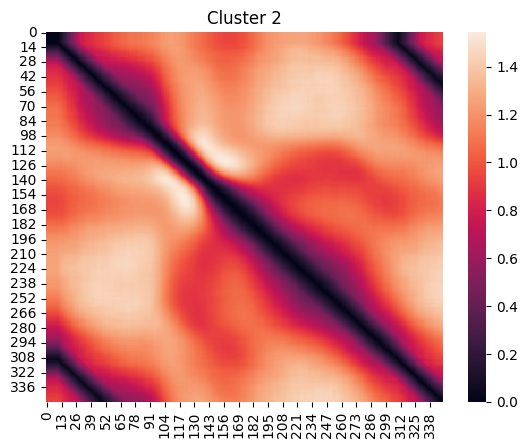

In [72]:
'''
RDM of average time traces, by cluster
'''
cluster_id = 2

idx_usnits = np.where(dat.loc[valid_idx, 'cluster'].values == cluster_id)[0]

# Select only the rows you want, based on cluster id
subset = dat.iloc[idx_units]["img_psth"]

# Convert to list of arrays
arrays = [np.asarray(x) for x in subset]
# shape: (units, time_points, images)
img_psth_array = np.stack(arrays, axis=0)

# average across images to get each unit's average psth
avg_psth = np.mean(img_psth_array, axis=2)
# normalize each timecourse
avg_psth_norm = zscore(avg_psth, axis=1)
# subset to specific time range
avg_psth_norm = avg_psth_norm[:, :350]

# rdm
metric = 'correlation'
rdm_vec = pdist(avg_psth_norm.T, metric=metric)
rdm = squareform(rdm_vec)
sns.heatmap(rdm)
plt.title(f'Cluster {cluster_id}')

  0%|                                                                                                                                                                             | 0/3 [00:00<?, ?it/s]

[RSA] Computing time×time similarity for cluster 0 ...


  0%|                                                                                                                                                                             | 0/3 [25:29<?, ?it/s]


NameError: name 'img_sel' is not defined

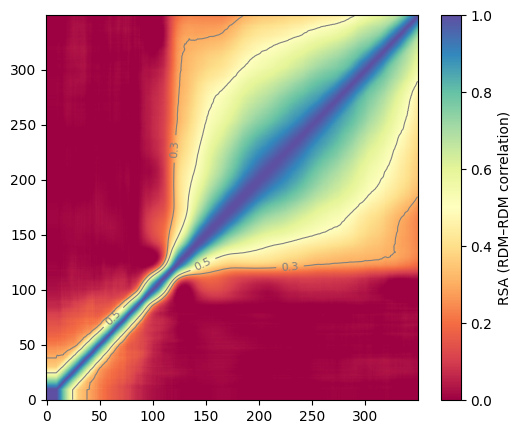

In [10]:
rsa_results = {}
for c in tqdm(range(best_k)):
    print(f"[RSA] Computing time×time similarity for cluster {c} ...")
    out = rsa_time_by_time_for_cluster(c)
    if out is None:
        continue
    rsa_mat = out
    rsa_results[c] = rsa_mat

    plt.figure(figsize=(6, 5))
    plt.imshow(rsa_mat, origin='lower', aspect='auto', vmin=0, vmax=1,
              cmap='Spectral')
    plt.colorbar(label="RSA (RDM–RDM correlation)")

    # add contour lines at correlation levels 0.3 and 0.5
    levels = [0.3, 0.5]
    contours = plt.contour(
        np.linspace(start, end-1, rsa_mat.shape[0]),  # x-axis
        np.linspace(start, end-1, rsa_mat.shape[1]),  # y-axis
        rsa_mat,
        levels=levels,
        colors='gray',
        linewidths=0.8,
    )
    plt.clabel(contours, fmt="%.1f", colors='gray', fontsize=8)

    plt.title(f"Time×Time RSA — Cluster {c}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Time (ms)")
    plt.tight_layout()

In [83]:
# =========================
# CONFIG (edit as needed)
# =========================
TYPE2_CLUSTER = 1          # set to the cluster label that corresponds to "Type 2"
MONKEY_ID = 3
ONSET_MS = 0              # stimulus onset (ms)
WINDOW_MS = 350            # analyze 0–300 ms post-onset
BIN_MS = 1                 # ms/bin (change if your PSTH bin differs)
THRESH_NORM_AVG = 0.3      # drop images below this normalized average response
N_SHOW = 5 

In [84]:
def is_anterior_face_roi(roi):
    if roi is None:
        return False
    tok0 = str(roi).split("_", 1)[0]  # first chunk only
    return "a" in tok0.lower()

mask = (
    (dat["monkey"] == MONKEY_ID) &
    (dat["cluster"] == TYPE2_CLUSTER) &
    (dat["roi"].apply(is_anterior_face_roi))
)

subset = dat.loc[mask].copy()

In [85]:
# =========================
# BUILD POPULATION PSTH PER IMAGE
# Per-unit scalar normalization = divide each unit by its max within [onset : onset+300ms] across ALL images.
# Then average normalized traces across units to get population PSTH per image.
# =========================
start = int(ONSET_MS / BIN_MS)
end   = start + int(WINDOW_MS / BIN_MS)

# infer sizes from first valid unit
sample = np.asarray(subset.iloc[0]["img_psth"])   # (time, images), e.g., (450, 1072)
T_full, N_img = sample.shape

pop_psth = np.zeros((end - start, N_img), dtype=float)
n_units = 0

for _, row in subset.iterrows():
    A = np.asarray(row["img_psth"])
    if A.ndim != 2 or A.shape[0] < end:
        continue
    W = A[start:end, :]          # (Twin, N_img)
    u_max = W.max()              # scalar per unit
    if not np.isfinite(u_max) or u_max <= 0:
        continue
    pop_psth += (W / u_max)
    n_units += 1

if n_units == 0:
    raise RuntimeError("No units passed windowing/normalization.")
pop_psth /= n_units  # average across units

In [87]:
max(norm_avg)

np.float64(0.06334204695541958)

In [86]:
# =========================
# IMAGE-WISE METRICS
# =========================
norm_avg   = pop_psth.mean(axis=0)       # mean over time
peak_amp   = pop_psth.max(axis=0)        # max over time (y-axis)
peak_idx   = pop_psth.argmax(axis=0)     # index of max
peak_lat_ms= peak_idx * BIN_MS           # ms since onset (x-axis)

# Apply exclusion: normalized average < 0.7
THRESH_NORM_AVG = 0
keep = norm_avg >= THRESH_NORM_AVG
kept_count = int(keep.sum())
if kept_count == 0:
    raise RuntimeError("No images passed THRESH_NORM_AVG; consider lowering it.")

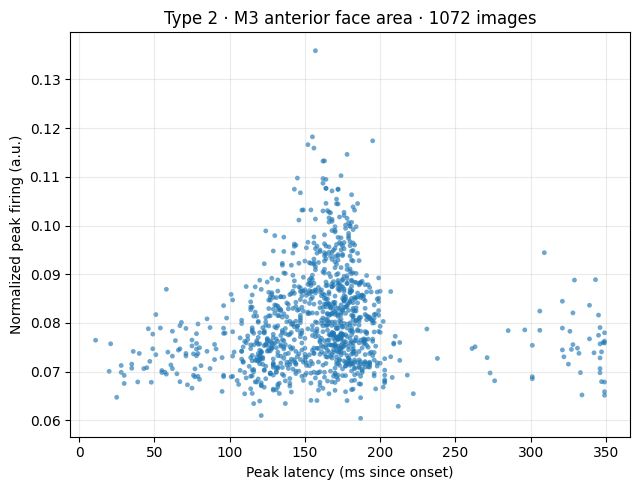

In [88]:
# =========================
# SCATTER: Peak latency (x) vs normalized peak firing (y)
# =========================
plt.figure(figsize=(6.5, 5))
plt.scatter(peak_lat_ms[keep], peak_amp[keep], s=12, alpha=0.65, edgecolor="none")
plt.xlabel("Peak latency (ms since onset)")
plt.ylabel("Normalized peak firing (a.u.)")
plt.title(f"Type 2 · M3 anterior face area · {kept_count} images")
plt.grid(alpha=0.25)
plt.tight_layout()

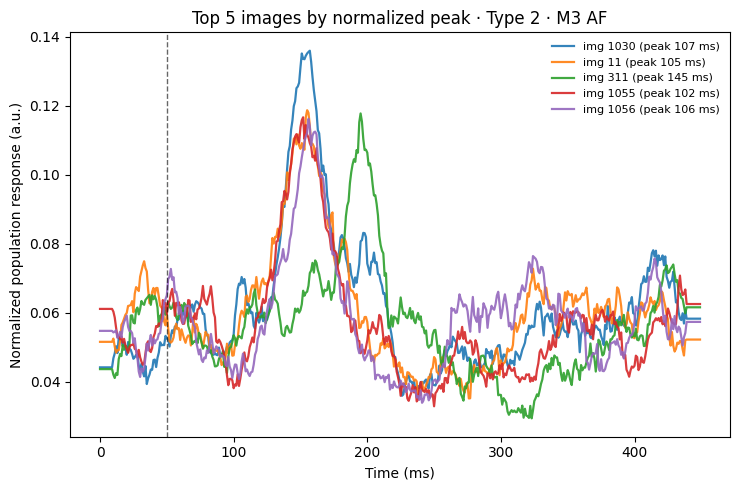

In [82]:
# =========================
# FULL TIME TRACES for top-N images (by normalized peak)
# Use the SAME per-unit scalar normalization (from 0–300 ms window across all images),
# but now plot the FULL 0..T_full trajectory.
# =========================
top_idx_within_kept = np.argsort(peak_amp[keep])[-N_SHOW:]          # positions within kept subset
kept_image_ids = np.where(keep)[0]                                   # original image indices
top_image_ids = kept_image_ids[top_idx_within_kept][::-1]            # top N, descending

time_axis_full = np.arange(T_full) * BIN_MS
pop_traces_full = []  # averaged across units per image

for img in top_image_ids:
    acc = np.zeros(T_full, dtype=float)
    cnt = 0
    for _, row in subset.iterrows():
        A = np.asarray(row["img_psth"])  # (T_full, N_img)
        if A.ndim != 2 or img >= A.shape[1] or A.shape[0] < end:
            continue
        # reuse same scalar normalization
        u_max = A[start:end, :].max()
        if not np.isfinite(u_max) or u_max <= 0:
            continue
        acc += (A[:, img] / u_max)
        cnt += 1
    if cnt > 0:
        pop_traces_full.append(acc / cnt)
    else:
        pop_traces_full.append(None)

plt.figure(figsize=(7.5, 5))
for img, tr in zip(top_image_ids, pop_traces_full):
    if tr is None:
        continue
    lbl = f"img {int(img)} (peak {int(peak_lat_ms[img])} ms)"
    plt.plot(time_axis_full, tr, lw=1.6, alpha=0.9, label=lbl)
plt.axvline(ONSET_MS, ls="--", lw=1, color="k", alpha=0.6)
plt.xlabel("Time (ms)")
plt.ylabel("Normalized population response (a.u.)")
plt.title(f"Top {N_SHOW} images by normalized peak · Type 2 · M3 AF")
plt.legend(fontsize=8, frameon=False)
plt.tight_layout()